# Set Environment

In [1]:
import torch
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import cupy as cp
import cudf
import cuml
from cuml.model_selection import GridSearchCV
import dask_ml.model_selection as dcv
from cuml.linear_model import LogisticRegression
import dask_cudf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import gc
from tqdm import tqdm
import time

In [2]:
torch.cuda.empty_cache()
gc.collect()

0

In [3]:
!nvidia-smi

Fri May 24 12:23:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   38C    P8              36W / 420W |    357MiB / 24576MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0" #select 3090 Super

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Set the device to GPU if CUDA is available
device = torch.device("cuda" if cuda_available else "cpu")
print(f"Using device: {device}")

if torch.cuda.device_count() >= 2:
    print(f"{torch.cuda.device_count()} GPUs are available")

num_gpus = torch.cuda.device_count()
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    
# Example of moving a tensor to GPU
if cuda_available:
    #Get ID
    gpu_id = torch.cuda.current_device()
    print(f"GPU ID being used: {gpu_id}")

    # Get the name of the current GPU
    gpu_name = torch.cuda.get_device_name(gpu_id)
    print(f"GPU in use is: {gpu_name}")

else:
    print("CUDA is not available. No GPU is being used.")

CUDA available: True
Using device: cuda
GPU 0: NVIDIA GeForce RTX 3090
GPU ID being used: 0
GPU in use is: NVIDIA GeForce RTX 3090


In [5]:
#3090: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4
#2060S: GPU-9234d598-4065-602a-8139-1b0b2bc70750

cluster = LocalCUDACluster(protocol="ucx", #use ucx for inter-gpu training (RDMA, exclude cpu)
                           enable_tcp_over_ucx=None,
                           CUDA_VISIBLE_DEVICES= "0") #sets first gpu as a worker
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 39.03 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:44923,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 39.03 GiB
Comm: ucx://127.0.0.1:52153,Total threads: 1
Dashboard: http://127.0.0.1:32797/status,Memory: 39.03 GiB
Nanny: ucx://127.0.0.1:54357,


2024-05-25 02:44:12,949 - distributed.nanny - WARNING - Restarting worker


# 1. Load Data

In [39]:
#read data to cpu
X_train_cpu = pd.read_csv(r"preprocessed_data/X_train.csv").drop(columns=['Unnamed: 0'])
y_train_cpu = pd.read_csv(r"preprocessed_data/y_train.csv").drop(columns=['Unnamed: 0'])
X_test_cpu = pd.read_csv(r"preprocessed_data/X_test.csv").drop(columns=['Unnamed: 0'])
y_test_cpu = pd.read_csv(r"preprocessed_data/y_test.csv").drop(columns=['Unnamed: 0'])

# Convert to NumPy arrays - Convert to numpy to be cuml readable
X_train_np = X_train_cpu.to_numpy()
y_train_np = y_train_cpu.to_numpy().ravel()  # .ravel() to ensure y is a 1D array if it's a single column
X_test_np = X_test_cpu.to_numpy()
y_test_np = y_test_cpu.to_numpy().ravel()

print(type(X_train_np))
print(type(y_train_np))
print(type(X_test_np))
print(type(y_test_np))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Initialize Scorer for CUML Results  


In [7]:
from sklearn.metrics import make_scorer
from cuml.metrics.accuracy import accuracy_score 

cuml_accuracy_scorer = make_scorer(accuracy_score)

# 2. SVC
Perform Gridsearch with cuML

In [8]:
%%time

import cuml.svm

#initialize param grid
params_svc = {'C': [0.001, 0.01, 0.1, 1], 
          'gamma': ['scale', 'auto', 0.1, 1,10],
          'probability': [True],
          'degree': [3, 5, 7, 10],
          'kernel': ['linear','rbf']
         }

#initialize Model
svc_mod = cuml.SVC()

clf_svc_mod = GridSearchCV(
    estimator=svc_mod,
    param_grid=params_svc, 
    cv=10, 
    scoring=cuml_accuracy_scorer,
    verbose=4
)

clf_svc_mod.fit(X_train_np, y_train_np)

best_params_svc_mod = clf_svc_mod.best_params_
best_score_svc_mod = clf_svc_mod.best_score_

print(f"Best parameters: {best_params_svc_mod}")
print(f"Best score: {best_score_svc_mod}")

Fitting 10 folds for each of 160 candidates, totalling 1600 fits
[W] [12:23:23.041014] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
[CV 1/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.870 total time=   5.6s
[CV 2/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.870 total time=   5.4s
[CV 3/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.867 total time=   5.4s
[CV 4/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.871 total time=   5.4s
[CV 5/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.873 total time=   5.6s
[CV 6/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.870 total time=   5.4s
[CV 7/10] END C=0.001, degree=3, gamma=scale, kernel=linear, probability=True;, score=0.

### 2.1 Train SVC Model with Best Parameters

In [27]:
%%time

# Train the model with the best parameters
# Best parameters: {'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
# Best score: 0.9548947811126709
# CPU times: user 13h 39min 57s, sys: 1h 39min 33s, total: 15h 19min 30s
# Wall time: 13h 58min 30s
svc_best = cuml.SVC(**best_params_svc_mod)
svc_best.fit(X_train_np, y_train_np)

CPU times: user 13.8 s, sys: 4.04 s, total: 17.8 s
Wall time: 15.7 s


SVC()

### 2.2 Predict on the test set

In [37]:
# Predict on the test set
y_pred = svc_best.predict(X_test_np)
y_proba = svc_best.predict_proba(X_test_np)[:, 1]

### 2.3 Construct Confusion Matrix

In [29]:
conf_matrix = confusion_matrix(y_test_np, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[17558   751]
 [  825 13238]]


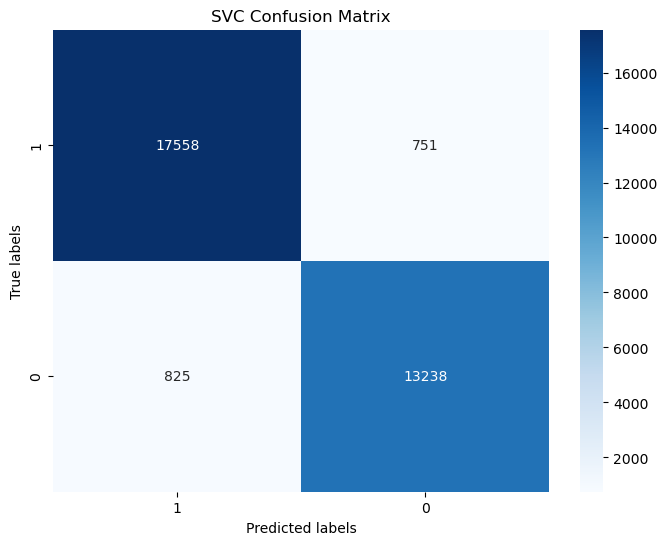

In [30]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVC Confusion Matrix')
plt.savefig('graphs/CM_SVC_9548.png')
plt.show()

### 2.4 Plot ROC Curve

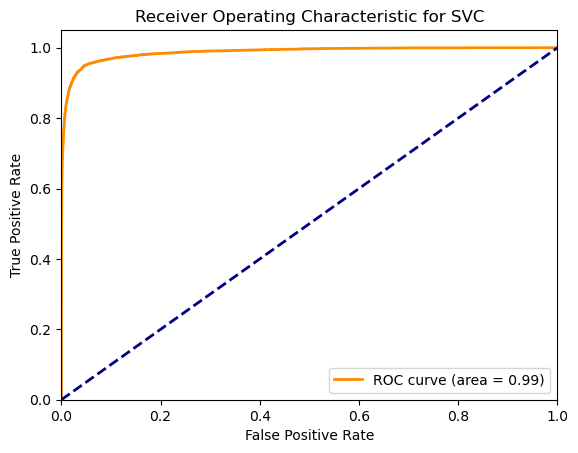

In [15]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVC')
plt.legend(loc='lower right')
plt.show()

### 2.5 Classification Report

In [38]:
report_df_SVC = pd.DataFrame(classification_report(y_test_np, 
                                               y_pred, 
                                                output_dict=True)).transpose()
report_df_SVC

,precision,recall,f1-score,support
0,0.955122,0.958982,0.957048,18309.000000
1,0.946315,0.941335,0.943819,14063.000000
accuracy,0.951316,0.951316,0.951316,0.951316
macro avg,0.950718,0.950159,0.950433,32372.000000
weighted avg,0.951296,0.951316,0.951301,32372.000000


# 3. Logistic Regression

In [18]:
%%time

from cuml.linear_model import LogisticRegression

#initialize param grid
param_grid_logistic = {
    'C': [0.001,0.01,0.1,1,10,100,1000],
    'penalty': ['l1', 'l2']
}

#initialize Model
log_reg = LogisticRegression(max_iter=10000)

clf_log_reg = GridSearchCV(estimator=log_reg, 
                               param_grid=param_grid_logistic, 
                               cv=10, 
                               scoring=cuml_accuracy_scorer
                          )

clf_log_reg.fit(X_train_np, y_train_np)

best_params_log_reg = clf_log_reg.best_params_
best_score_log_reg = clf_log_reg.best_score_

print(f"Best parameters: {best_params_log_reg}")
print(f"Best score: {best_score_log_reg}")

Best parameters: {'C': 100, 'penalty': 'l2'}
Best score: 0.8770395815372467
CPU times: user 3min 18s, sys: 2.33 s, total: 3min 21s
Wall time: 3min 16s


### 3.1 Train LR Model with Best Parameters

In [31]:
%%time

# Best parameters: {'C': 100, 'penalty': 'l2'}
# Best score: 0.8770395815372467
# CPU times: user 3min 18s, sys: 2.33 s, total: 3min 21s
# Wall time: 3min 16s

# Train the model with the best parameters
lr_best = LogisticRegression(**best_params_log_reg, max_iter=10000)
lr_best.fit(X_train_np, y_train_np)

CPU times: user 212 ms, sys: 16.5 ms, total: 229 ms
Wall time: 224 ms


LogisticRegression()

### 3.2 Predict on the test set

In [32]:
# Predict on the test set
y_pred = lr_best.predict(X_test_np)
y_proba = lr_best.predict_proba(X_test_np)[:, 1]

### 3.3 Construct Confusion Matrix (LR)

In [33]:
conf_matrix = confusion_matrix(y_test_np, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[16170  2139]
 [ 2096 11967]]


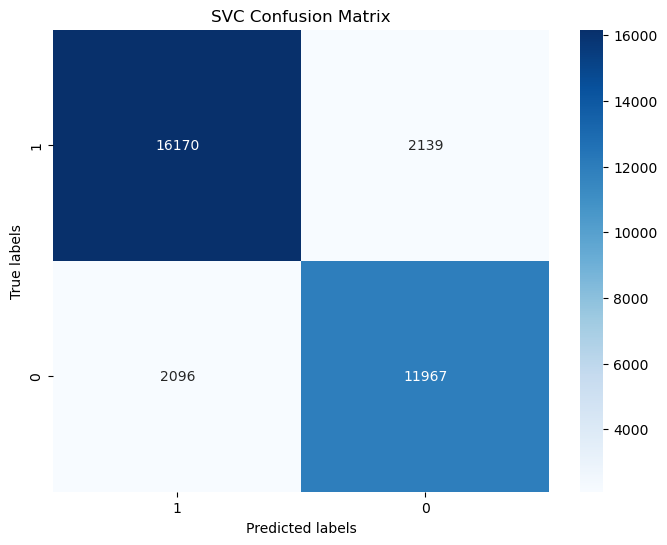

In [34]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['1', '0'], yticklabels=['1', '0'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVC Confusion Matrix')
plt.savefig('graphs/CM_LR_8770.png')
plt.show()

### 3.4 Plot ROC Curve

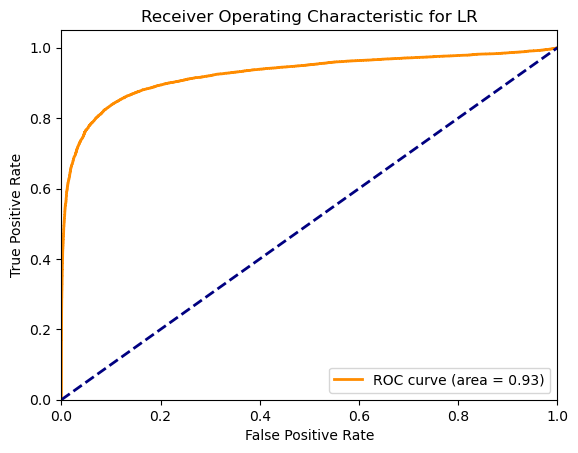

In [24]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test_np, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LR')
plt.legend(loc='lower right')
plt.show()

### 3.5 Classification Report

In [36]:
report_df_LR = pd.DataFrame(classification_report(y_test_np, 
                                               y_pred, 
                                                output_dict=True)).transpose()
report_df_LR

,precision,recall,f1-score,support
0,0.885251,0.883172,0.884211,18309.000000
1,0.848362,0.850956,0.849657,14063.000000
accuracy,0.869177,0.869177,0.869177,0.869177
macro avg,0.866807,0.867064,0.866934,32372.000000
weighted avg,0.869226,0.869177,0.869200,32372.000000
